# Set-up Environment

In [1]:
pip install semopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import descartes
import json
import folium
import semopy
import seaborn as sns
import io
from sklearn import preprocessing
from numpy.core.numeric import NaN
import math
import statistics
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

%matplotlib inline


# Processing

## US South Region States

In [4]:
#based on wiki US South region is made up of these 16 states
southern_states = ['DE','FL','GA','MD','NC','SC','VA','WV','AL','KY','MS','TN','AR','LA','OK','TX']

###**Listings**

In [5]:
df_list = pd.read_csv("listings.csv", header=None)
#define column name
df_list.columns = df_list.iloc[0]
df_list = df_list.drop(columns=['has_availability']) #this column is all empty
df_list = df_list[df_list.state.isin(southern_states)]
#Drop any row with N/A price
df_list = df_list[df_list.price != np.nan]
df_list = df_list.reset_index(drop=True) #must include this to help concate!

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,2,3,5,6,9,10,11,13,14,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
df_list['longitude'] = df_list.longitude.astype(float)
df_list['latitude'] = df_list.latitude.astype(float)
df_list['price'] = df_list['price'].str.replace('$', '')
df_list['price'] = df_list['price'].str.replace(',', '')
df_list['price'] = df_list['price'].astype(float)

In [7]:
def clean_zip(x):
  x = str(x)
  return x[:5]

df_list['zipcode'] = df_list['zipcode'].apply(clean_zip)
df_list = df_list[df_list.zipcode != 'nan']

In [8]:
#drop na in bathroom, bedroom, bed, name and zipcode
df_list = df_list.dropna(subset = ['bathrooms', 'bedrooms', 'beds', 'name', 'zipcode'])
df_list = df_list.reset_index(drop=True) 
df_list

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,host_id,...,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,state,weekly_price,zipcode
0,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,2600734,...,10.0,9.0,10.0,9.0,96.0,10.0,Entire home/apt,NC,$650.00,28806
1,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",17,1.0,Real Bed,1.0,2.0,strict,Asheville,4295819,...,10.0,10.0,10.0,9.0,96.0,9.0,Entire home/apt,NC,NaN,28806
2,1.0,"{TV,""Wireless Internet"",""Air Conditioning"",Kit...",29,1.0,Real Bed,1.0,1.0,flexible,Asheville,36223353,...,NaN,NaN,NaN,NaN,NaN,NaN,Private room,NC,NaN,28806
3,6.0,"{Internet,""Wireless Internet"",""Air Conditionin...",28,2.5,Real Bed,1.0,6.0,moderate,Asheville,746673,...,NaN,NaN,NaN,NaN,NaN,NaN,Shared room,NC,NaN,28806
4,6.0,"{Internet,""Wireless Internet"",""Free Parking on...",25,2.5,Real Bed,1.0,6.0,moderate,Asheville,746673,...,10.0,9.0,9.0,9.0,93.0,10.0,Shared room,NC,NaN,28806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18847,8.0,"{TV,""Air conditioning"",""Wheelchair accessible""...",23,2.5,Real Bed,3.0,3.0,flexible,New Orleans,62928713,...,10.0,10.0,10.0,10.0,100.0,10.0,Entire home/apt,LA,NaN,70129
18848,1.0,{},30,1.0,Real Bed,1.0,1.0,flexible,New Orleans,53724682,...,NaN,NaN,NaN,NaN,NaN,NaN,Private room,LA,NaN,70129
18849,2.0,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",26,1.0,Real Bed,1.0,1.0,flexible,Metairie,20658221,...,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,LA,NaN,70005
18850,3.0,"{TV,""Wireless Internet"",""Air conditioning"",""Fr...",28,1.0,Real Bed,0.0,1.0,strict,Arabi,131027427,...,10.0,10.0,10.0,10.0,100.0,10.0,Entire home/apt,LA,NaN,70032


In [9]:
df_list.state.unique()

array(['NC', 'TX', 'TN', 'LA'], dtype=object)

<AxesSubplot:ylabel='Frequency'>

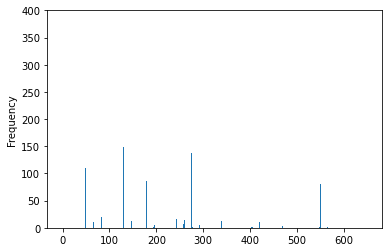

In [10]:
#cut outliers, see histogram for prices. You can choose the outlier cutoff line later
sub1 = df_list[df_list.price<650]
sub1['price'].plot.hist(bins=5000, ylim=(0,400))

In [11]:
sub2 = sub1[sub1.state == 'NC']
sub3 = sub1[sub1.state == 'TX']
sub4 = sub1[sub1.state == 'TN']
sub5 = sub1[sub1.state == 'LA']

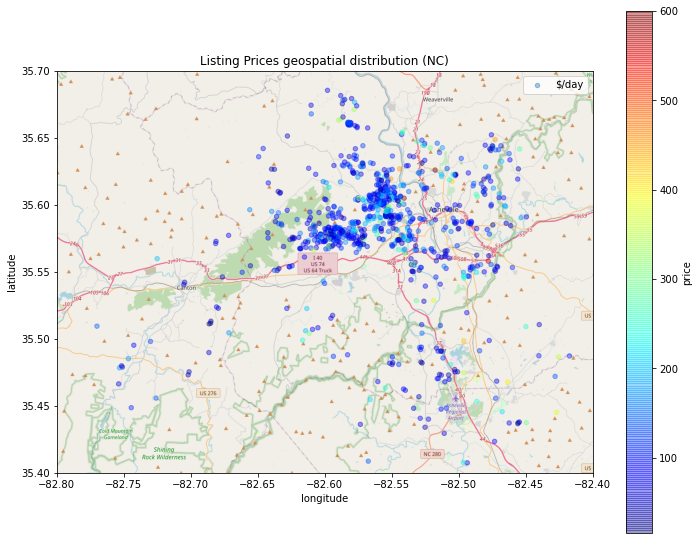

In [12]:
#Visualize listing prices geospatial distribution 
plt.figure(figsize=(12, 9.6)) #change here proportionally to make img bigger
img=plt.imread('NC.png')
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(img,zorder=0,extent=[-82.8, -82.4, 35.4, 35.7])
ax=plt.gca()
#using scatterplot again
sub2.plot(kind='scatter', x='longitude', y='latitude', label='$/day', c='price', ax=ax, title='Listing Prices geospatial distribution (NC)',
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)

plt.legend()
plt.show()

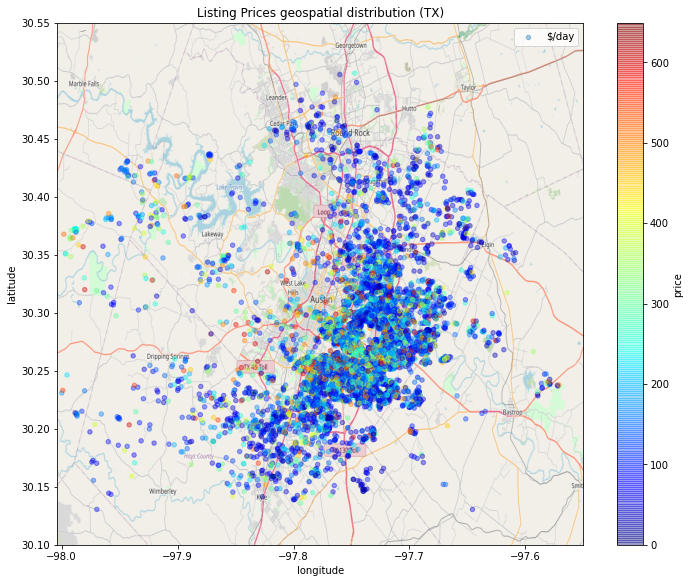

In [13]:
plt.figure(figsize=(12, 9.6)) #change here proportionally to make img bigger
img=plt.imread('TX.png')
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(img,zorder=0,extent=[-98.004, -97.55, 30.1, 30.55])
ax=plt.gca()
#using scatterplot again
sub3[sub3.longitude>-98].plot(kind='scatter', x='longitude', y='latitude', label='$/day', c='price', ax=ax, title='Listing Prices geospatial distribution (TX)',
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)

plt.legend()
plt.show()

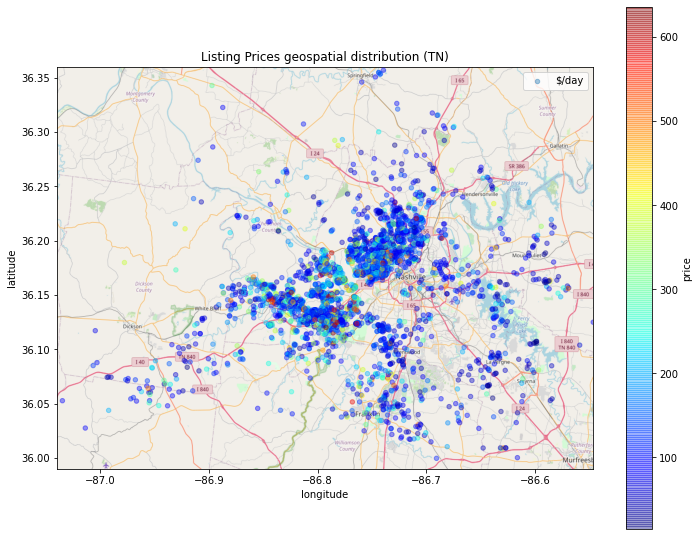

In [14]:
plt.figure(figsize=(12, 9.6)) #change here proportionally to make img bigger
img=plt.imread('TN.png')
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(img,zorder=0,extent=[-87.04, -86.547, 35.99, 36.36])
ax=plt.gca()
#using scatterplot again
sub4.plot(kind='scatter', x='longitude', y='latitude', label='$/day', c='price', ax=ax, title='Listing Prices geospatial distribution (TN)',
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)

plt.legend()
plt.show()

In [15]:
su = sub5
up = su.latitude.min()
down = su.latitude.max()
left = su.longitude.min()
right = su.longitude.max()
print("上下左右：", up, down, left, right)

上下左右： 29.89826583262301 30.138585757541552 -90.13511068204664 -89.75333791955971


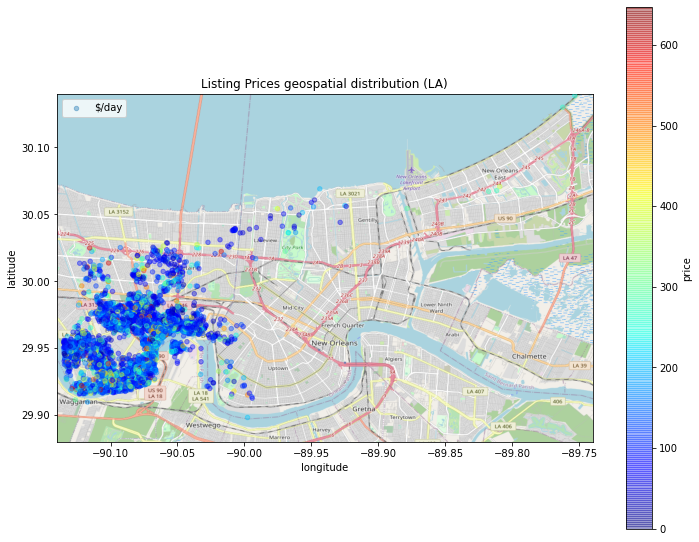

In [16]:
plt.figure(figsize=(12, 9.6)) #change here proportionally to make img bigger
img=plt.imread('LA.png')
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(img,zorder=0,extent=[-90.14, -89.74, 29.88, 30.14])
ax=plt.gca()
#using scatterplot again
sub5.plot(kind='scatter', x='longitude', y='latitude', label='$/day', c='price', ax=ax, title='Listing Prices geospatial distribution (LA)',
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)

plt.legend()
plt.show()

## Calendar

In [17]:
raw_df_calendar = pd.read_csv("calendar.csv")

In [18]:
#check:
columns_w_NA = []
for column in list(raw_df_calendar.columns):
    print("type of columns: ", column, "is ", raw_df_calendar[str(column)].dtype)
    print("number of NA values in column ", column, " : ", raw_df_calendar[str(column)].isnull().values.sum())
    if (raw_df_calendar[str(column)].isnull().values.sum() > 0):
        columns_w_NA.append(str(column))
print(columns_w_NA)

type of columns:  listing_id is  int64
number of NA values in column  listing_id  :  0
type of columns:  date is  object
number of NA values in column  date  :  0
type of columns:  available is  object
number of NA values in column  available  :  0
type of columns:  price is  object
number of NA values in column  price  :  8561996
type of columns:  metro_area is  object
number of NA values in column  metro_area  :  0
['price']


In [19]:
#drop price that's empty, then convert price to float
cleaned_calendar = raw_df_calendar.dropna(subset = ['price'])
cleaned_calendar = cleaned_calendar.reset_index(drop=True) 
cleaned_calendar['price'] = cleaned_calendar['price'].str.replace('$', '')
cleaned_calendar['price'] = cleaned_calendar['price'].str.replace(',', '')
cleaned_calendar['price'] = cleaned_calendar['price'].astype(float)
cleaned_calendar

,listing_id,date,available,price,metro_area
0,665257,2016-05-31,t,105.0,asheville
1,665257,2016-06-01,t,105.0,asheville
2,665257,2016-06-02,t,105.0,asheville
3,665257,2016-06-03,t,105.0,asheville
4,665257,2016-06-04,t,105.0,asheville
...,...,...,...,...,...
9821954,17383627,2017-05-13,t,500.0,LA
9821955,17383627,2017-05-12,t,500.0,LA
9821956,17383627,2017-05-11,t,500.0,LA
9821957,17383627,2017-05-10,t,500.0,LA


In [20]:
#cast datetype
cleaned_calendar['date'] = pd.to_datetime(cleaned_calendar['date'])
cleaned_calendar.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                float64
metro_area            object
dtype: object

In [21]:
#checkpoint 
# cleaned_calendar.to_csv(data_dir + "cleaned_calendar20210715.csv")

In [22]:
#change the name of price column to identify easier when merging 
cleaned_calendar.columns = ['listing_id', 'date', 'available', 'price_from_calendar', 'metro_area']
cleaned_calendar.columns

Index(['listing_id', 'date', 'available', 'price_from_calendar', 'metro_area'], dtype='object')

In [23]:
#converting non numerical columns to string or some columns to integer
cleaned_southern_df_listings = df_list
non_numerical_columns = ['amenities', 'bed_type', 'cancellation_policy', 'city', 'instant_bookable', 'metropolitan', 'name', 'property_type', 'room_type', 'state']
for column in non_numerical_columns:
    cleaned_southern_df_listings[column] = cleaned_southern_df_listings[column].astype("string")
integer_columns = ['id','bathrooms','bedrooms','beds'] #deal with zipcode at the end 
for column in integer_columns:
    cleaned_southern_df_listings[column] = cleaned_southern_df_listings[column].astype(float)
    cleaned_southern_df_listings[column] = cleaned_southern_df_listings[column].astype("int64")
cleaned_southern_df_listings.dtypes

0
accommodates                    object
amenities                       string
availability_30                 object
bathrooms                        int64
bed_type                        string
bedrooms                         int64
beds                             int64
cancellation_policy             string
city                            string
host_id                         object
id                               int64
instant_bookable                string
latitude                       float64
longitude                      float64
metropolitan                    string
name                            string
price                          float64
property_type                   string
review_scores_checkin           object
review_scores_cleanliness       object
review_scores_communication     object
review_scores_location          object
review_scores_rating            object
review_scores_value             object
room_type                       string
state                  

In [24]:
#merge 
left = cleaned_southern_df_listings
right = cleaned_calendar
merged_calendar_listing = pd.merge(left, right, how = 'right', left_on=['id'], right_on= ['listing_id'])
merged_calendar_listing

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,host_id,...,review_scores_value,room_type,state,weekly_price,zipcode,listing_id,date,available,price_from_calendar,metro_area
0,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,2600734,...,10.0,Entire home/apt,NC,$650.00,28806,665257,2016-05-31,t,105.0,asheville
1,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,2600734,...,10.0,Entire home/apt,NC,$650.00,28806,665257,2016-06-01,t,105.0,asheville
2,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,2600734,...,10.0,Entire home/apt,NC,$650.00,28806,665257,2016-06-02,t,105.0,asheville
3,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,2600734,...,10.0,Entire home/apt,NC,$650.00,28806,665257,2016-06-03,t,105.0,asheville
4,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,2600734,...,10.0,Entire home/apt,NC,$650.00,28806,665257,2016-06-04,t,105.0,asheville
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9821954,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,<NA>,NaN,...,NaN,<NA>,<NA>,NaN,NaN,17383627,2017-05-13,t,500.0,LA
9821955,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,<NA>,NaN,...,NaN,<NA>,<NA>,NaN,NaN,17383627,2017-05-12,t,500.0,LA
9821956,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,<NA>,NaN,...,NaN,<NA>,<NA>,NaN,NaN,17383627,2017-05-11,t,500.0,LA
9821957,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,<NA>,NaN,...,NaN,<NA>,<NA>,NaN,NaN,17383627,2017-05-10,t,500.0,LA


In [25]:
# drop all listing thats not in the cleaned listing data
cleaned_merged_calendar_listing = merged_calendar_listing.dropna(subset = ['price'])
cleaned_merged_calendar_listing = cleaned_merged_calendar_listing.reset_index(drop=True) 
cleaned_merged_calendar_listing

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,host_id,...,review_scores_value,room_type,state,weekly_price,zipcode,listing_id,date,available,price_from_calendar,metro_area
0,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,2600734,...,10.0,Entire home/apt,NC,$650.00,28806,665257,2016-05-31,t,105.0,asheville
1,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,2600734,...,10.0,Entire home/apt,NC,$650.00,28806,665257,2016-06-01,t,105.0,asheville
2,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,2600734,...,10.0,Entire home/apt,NC,$650.00,28806,665257,2016-06-02,t,105.0,asheville
3,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,2600734,...,10.0,Entire home/apt,NC,$650.00,28806,665257,2016-06-03,t,105.0,asheville
4,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,2600734,...,10.0,Entire home/apt,NC,$650.00,28806,665257,2016-06-04,t,105.0,asheville
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3541803,2.0,{},29,1.0,Real Bed,1.0,1.0,flexible,houston,121175318,...,NaN,Shared room,TX,NaN,90706,17756859,2017-05-08,t,154.0,LA
3541804,2.0,{},29,1.0,Real Bed,1.0,1.0,flexible,houston,121175318,...,NaN,Shared room,TX,NaN,90706,17756859,2017-05-07,t,154.0,LA
3541805,2.0,{},29,1.0,Real Bed,1.0,1.0,flexible,houston,121175318,...,NaN,Shared room,TX,NaN,90706,17756859,2017-05-06,t,154.0,LA
3541806,2.0,{},29,1.0,Real Bed,1.0,1.0,flexible,houston,121175318,...,NaN,Shared room,TX,NaN,90706,17756859,2017-05-05,t,154.0,LA


In [26]:
print("date range: ", str(cleaned_merged_calendar_listing['date'].dt.date.min()) + ' to ' +str(cleaned_merged_calendar_listing['date'].dt.date.max()))
print("count for unique listing: ", len(cleaned_merged_calendar_listing.id.unique()))
print("count for unique host id: ", len(cleaned_merged_calendar_listing.host_id.unique()))

date range:  2016-04-20 to 2018-06-01
count for unique listing:  16034
count for unique host id:  11211


In [27]:
#converting non numerical columns to string or some columns to integer
non_numerical_columns = ['available', 'metro_area', 'amenities']
for column in non_numerical_columns:
    cleaned_merged_calendar_listing[column] = cleaned_merged_calendar_listing[column].astype("string")
integer_columns = ['zipcode','id','host_id', 'bedrooms', 'beds', 'accommodates', 'availability_30', 'bathrooms'] 
for column in integer_columns:
    cleaned_merged_calendar_listing[column] = cleaned_merged_calendar_listing[column].astype(float)
    cleaned_merged_calendar_listing[column] = cleaned_merged_calendar_listing[column].astype("int64")
#double check
print(cleaned_merged_calendar_listing['price'].equals(cleaned_merged_calendar_listing['price_from_calendar']))
#one last check:
columns_w_NA = []
for column in list(cleaned_merged_calendar_listing.columns):
    print("type of columns: ", column, "is ", cleaned_merged_calendar_listing[str(column)].dtype)
    print("number of NA values in column ", column, " : ", cleaned_merged_calendar_listing[str(column)].isnull().values.sum())
    if (cleaned_merged_calendar_listing[str(column)].isnull().values.sum() > 0):
        columns_w_NA.append(str(column))
print(columns_w_NA)

False
type of columns:  accommodates is  int64
number of NA values in column  accommodates  :  0
type of columns:  amenities is  string
number of NA values in column  amenities  :  0
type of columns:  availability_30 is  int64
number of NA values in column  availability_30  :  0
type of columns:  bathrooms is  int64
number of NA values in column  bathrooms  :  0
type of columns:  bed_type is  string
number of NA values in column  bed_type  :  0
type of columns:  bedrooms is  int64
number of NA values in column  bedrooms  :  0
type of columns:  beds is  int64
number of NA values in column  beds  :  0
type of columns:  cancellation_policy is  string
number of NA values in column  cancellation_policy  :  0
type of columns:  city is  string
number of NA values in column  city  :  0
type of columns:  host_id is  int64
number of NA values in column  host_id  :  0
type of columns:  id is  int64
number of NA values in column  id  :  0
type of columns:  instant_bookable is  string
number of NA 

In [28]:
#check point
# cleaned_merged_calendar_listing.to_csv(data_dir + "cleaned_merged_calendar_listing20210715.csv")

## Real Estate

In [29]:
raw_df_real_estate = pd.read_csv("real_estate.csv")
raw_df_real_estate

,type,zipcode,city,state,metro,county,size_rank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,ZHVI,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1137500,1137700,1152700,1156000.0,1140200,1130000,1131900,1149600,1198400,1247000
1,ZHVI,60657,Chicago,IL,Chicago,Cook,2,146700.0,146500.0,146300.0,...,318200,318100,318800,320200.0,320800,322000,323800,326100,327800,329100
2,ZHVI,60614,Chicago,IL,Chicago,Cook,3,198000.0,195500.0,194200.0,...,401900,406000,414100,417800.0,417400,418400,414100,404100,406400,415500
3,ZHVI,79936,El Paso,TX,El Paso,El Paso,4,70800.0,71000.0,71000.0,...,113800,113900,114100,114500.0,114900,115000,114700,114700,114800,114700
4,ZHVI,60640,Chicago,IL,Chicago,Cook,5,102300.0,101300.0,100700.0,...,198800,199200,200100,201500.0,203000,205100,206700,206500,206200,206700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29106,ZRI,12720,Bethel,NY,NaN,Sullivan,15907,NaN,NaN,NaN,...,1185,1181,1174,1167.0,1156,1162,1175,1194,1202,1206
29107,ZRI,1338,Shelburne Falls,MA,Greenfield Town,Franklin,15908,NaN,NaN,NaN,...,1769,1772,1775,1780.0,1786,1790,1797,1798,1796,1795
29108,ZRI,21405,Annapolis,MD,Baltimore,Anne Arundel,15909,NaN,NaN,NaN,...,4048,4005,3888,3729.0,3563,3493,3474,3496,3488,3471
29109,ZRI,85220,Apache Junction,AZ,Phoenix,Pinal,15910,NaN,NaN,NaN,...,1007,1018,1035,1052.0,1061,1060,1058,1065,1074,1080


In [30]:
#raw real estate data in southern states that has airbnb listing: 3658 rows × 262 columns 
southern_states_with_listing_data = list(cleaned_merged_calendar_listing.state.unique())
raw_df_southern_real_estate = raw_df_real_estate[raw_df_real_estate.state.isin(southern_states_with_listing_data)]
raw_df_southern_real_estate = raw_df_southern_real_estate.reset_index(drop=True)
raw_df_southern_real_estate

,type,zipcode,city,state,metro,county,size_rank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,ZHVI,79936,El Paso,TX,El Paso,El Paso,4,70800.0,71000.0,71000.0,...,113800,113900,114100,114500.0,114900,115000,114700,114700,114800,114700
1,ZHVI,77084,Houston,TX,Houston,Harris,6,75600.0,75400.0,75100.0,...,160400,160300,160400,159200.0,157000,154700,153500,154200,156700,158200
2,ZHVI,75070,McKinney,TX,Dallas-Fort Worth,Collin,8,NaN,NaN,NaN,...,298800,301000,303400,304800.0,305600,307400,309800,312100,314100,315300
3,ZHVI,77449,Cypress,TX,Houston,Harris,10,72100.0,72300.0,72100.0,...,160500,161800,162600,161600.0,159100,156400,155200,156400,159400,161000
4,ZHVI,37211,Nashville,TN,Nashville,Davidson,14,80900.0,81600.0,82500.0,...,204500,207500,210500,213400.0,215600,217100,218900,222100,224900,226800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3653,ZRI,38259,Trimble,TN,Dyersburg,Dyer,15843,NaN,NaN,NaN,...,647,626,630,664.0,695,721,726,726,718,719
3654,ZRI,37028,Bumpus Mills,TN,NaN,Stewart,15847,NaN,NaN,NaN,...,785,772,764,760.0,759,760,760,762,758,755
3655,ZRI,38241,Palmersville,TN,Martin,Weakley,15852,NaN,NaN,NaN,...,837,826,816,811.0,807,805,807,809,811,809
3656,ZRI,38076,Williston,TN,Memphis,Fayette,15857,NaN,NaN,NaN,...,1208,1199,1196,1195.0,1205,1220,1221,1213,1197,1189


In [31]:
#initial check
columns_w_NA = []
for column in list(raw_df_southern_real_estate.columns):
    print("type of columns: ", column, "is ", raw_df_southern_real_estate[str(column)].dtype)
    print("number of NA values in column ", column, " : ", raw_df_southern_real_estate[str(column)].isnull().values.sum())
    if (raw_df_southern_real_estate[str(column)].isnull().values.sum() > 0):
        columns_w_NA.append(str(column))
print(columns_w_NA)

type of columns:  type is  object
number of NA values in column  type  :  0
type of columns:  zipcode is  int64
number of NA values in column  zipcode  :  0
type of columns:  city is  object
number of NA values in column  city  :  0
type of columns:  state is  object
number of NA values in column  state  :  0
type of columns:  metro is  object
number of NA values in column  metro  :  388
type of columns:  county is  object
number of NA values in column  county  :  0
type of columns:  size_rank is  int64
number of NA values in column  size_rank  :  0
type of columns:  1996-04 is  float64
number of NA values in column  1996-04  :  2862
type of columns:  1996-05 is  float64
number of NA values in column  1996-05  :  2847
type of columns:  1996-06 is  float64
number of NA values in column  1996-06  :  2841
type of columns:  1996-07 is  float64
number of NA values in column  1996-07  :  2841
type of columns:  1996-08 is  float64
number of NA values in column  1996-08  :  2829
type of column

type of columns:  2012-11 is  float64
number of NA values in column  2012-11  :  16
type of columns:  2012-12 is  float64
number of NA values in column  2012-12  :  16
type of columns:  2013-01 is  float64
number of NA values in column  2013-01  :  15
type of columns:  2013-02 is  float64
number of NA values in column  2013-02  :  11
type of columns:  2013-03 is  float64
number of NA values in column  2013-03  :  11
type of columns:  2013-04 is  float64
number of NA values in column  2013-04  :  11
type of columns:  2013-05 is  float64
number of NA values in column  2013-05  :  11
type of columns:  2013-06 is  float64
number of NA values in column  2013-06  :  11
type of columns:  2013-07 is  float64
number of NA values in column  2013-07  :  7
type of columns:  2013-08 is  float64
number of NA values in column  2013-08  :  0
type of columns:  2013-09 is  float64
number of NA values in column  2013-09  :  0
type of columns:  2013-10 is  float64
number of NA values in column  2013-10  :

In [32]:
#converting num numerical columns into string type 
non_numerical_columns = ['type', 'city', 'state', 'metro', 'county']
for column in non_numerical_columns:
    raw_df_southern_real_estate[column] = raw_df_southern_real_estate[column].astype("string")
raw_df_southern_real_estate.dtypes

type       string
zipcode     int64
city       string
state      string
metro      string
            ...  
2017-02     int64
2017-03     int64
2017-04     int64
2017-05     int64
2017-06     int64
Length: 262, dtype: object

In [33]:
#clean zipcode 
raw_df_southern_real_estate['zipcode'] = raw_df_southern_real_estate['zipcode'].apply(pd.to_numeric, errors='coerce')
raw_df_southern_real_estate['zipcode'] = raw_df_southern_real_estate['zipcode'].astype(float)
raw_df_southern_real_estate['zipcode'] = raw_df_southern_real_estate['zipcode'].astype("int64")

#only taking first 5 digit of zipcode 
def clean_zip(x):
    x = str(x)
    return x[:5]
raw_df_southern_real_estate['zipcode'] = raw_df_southern_real_estate['zipcode'].apply(clean_zip)
raw_df_southern_real_estate = raw_df_southern_real_estate[raw_df_southern_real_estate.zipcode != 'nan']
raw_df_southern_real_estate

,type,zipcode,city,state,metro,county,size_rank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,ZHVI,79936,El Paso,TX,El Paso,El Paso,4,70800.0,71000.0,71000.0,...,113800,113900,114100,114500.0,114900,115000,114700,114700,114800,114700
1,ZHVI,77084,Houston,TX,Houston,Harris,6,75600.0,75400.0,75100.0,...,160400,160300,160400,159200.0,157000,154700,153500,154200,156700,158200
2,ZHVI,75070,McKinney,TX,Dallas-Fort Worth,Collin,8,NaN,NaN,NaN,...,298800,301000,303400,304800.0,305600,307400,309800,312100,314100,315300
3,ZHVI,77449,Cypress,TX,Houston,Harris,10,72100.0,72300.0,72100.0,...,160500,161800,162600,161600.0,159100,156400,155200,156400,159400,161000
4,ZHVI,37211,Nashville,TN,Nashville,Davidson,14,80900.0,81600.0,82500.0,...,204500,207500,210500,213400.0,215600,217100,218900,222100,224900,226800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3653,ZRI,38259,Trimble,TN,Dyersburg,Dyer,15843,NaN,NaN,NaN,...,647,626,630,664.0,695,721,726,726,718,719
3654,ZRI,37028,Bumpus Mills,TN,<NA>,Stewart,15847,NaN,NaN,NaN,...,785,772,764,760.0,759,760,760,762,758,755
3655,ZRI,38241,Palmersville,TN,Martin,Weakley,15852,NaN,NaN,NaN,...,837,826,816,811.0,807,805,807,809,811,809
3656,ZRI,38076,Williston,TN,Memphis,Fayette,15857,NaN,NaN,NaN,...,1208,1199,1196,1195.0,1205,1220,1221,1213,1197,1189


In [34]:
#cast zipcode
raw_df_southern_real_estate['zipcode'] = raw_df_southern_real_estate['zipcode'].astype("int64")
raw_df_southern_real_estate.dtypes

type       string
zipcode     int64
city       string
state      string
metro      string
            ...  
2017-02     int64
2017-03     int64
2017-04     int64
2017-05     int64
2017-06     int64
Length: 262, dtype: object

In [35]:
#only takes ZRI and drop columns with no data --> check 2134 rows × 87 columns
df_ZRI = raw_df_southern_real_estate[raw_df_southern_real_estate['type'] == "ZRI"]
df_ZRI = df_ZRI.reset_index(drop=True)
columns_to_drop = []
for column in list(df_ZRI.columns):
    if (df_ZRI[str(column)].isnull().values.sum()) == len(df_ZRI):
        columns_to_drop.append(str(column))
df_ZRI_clean = df_ZRI.drop(columns = columns_to_drop)
df_ZRI_clean

,type,zipcode,city,state,metro,county,size_rank,2010-11,2010-12,2011-01,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,ZRI,79936,El Paso,TX,El Paso,El Paso,5,1082.0,1079.0,1075.0,...,1014,1013,1006,1000.0,998,1000,1001,1001,999,998
1,ZRI,77084,Houston,TX,Houston,Harris,9,1270.0,1261.0,1254.0,...,1438,1439,1440,1441.0,1439,1433,1423,1415,1410,1413
2,ZRI,75070,McKinney,TX,Dallas-Fort Worth,Collin,11,1581.0,1583.0,1590.0,...,1936,1940,1943,1946.0,1947,1947,1946,1943,1941,1939
3,ZRI,77494,Cinco Ranch,TX,Houston,Fort Bend,13,2245.0,2247.0,2233.0,...,2305,2286,2262,2237.0,2221,2220,2230,2237,2239,2233
4,ZRI,77449,Cypress,TX,Houston,Harris,14,1287.0,1280.0,1271.0,...,1440,1441,1442,1441.0,1438,1432,1422,1414,1408,1408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,ZRI,38259,Trimble,TN,Dyersburg,Dyer,15843,784.0,779.0,778.0,...,647,626,630,664.0,695,721,726,726,718,719
2130,ZRI,37028,Bumpus Mills,TN,<NA>,Stewart,15847,808.0,815.0,820.0,...,785,772,764,760.0,759,760,760,762,758,755
2131,ZRI,38241,Palmersville,TN,Martin,Weakley,15852,799.0,805.0,815.0,...,837,826,816,811.0,807,805,807,809,811,809
2132,ZRI,38076,Williston,TN,Memphis,Fayette,15857,1118.0,1142.0,1162.0,...,1208,1199,1196,1195.0,1205,1220,1221,1213,1197,1189


In [36]:
#select ZRI with zipcode that apprears in the listing dataset --> check 107 rows × 87 columns
zipcode_to_select = list(cleaned_merged_calendar_listing.zipcode.unique())
ZRI_in_listing_area = df_ZRI_clean[df_ZRI_clean.zipcode.isin(zipcode_to_select)]
ZRI_in_listing_area = ZRI_in_listing_area.reset_index(drop=True)
ZRI_in_listing_area

,type,zipcode,city,state,metro,county,size_rank,2010-11,2010-12,2011-01,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,ZRI,37211,Nashville,TN,Nashville,Davidson,19,1076.0,1070.0,1063.0,...,1501,1508,1513,1518.0,1518,1513,1510,1518,1532,1549
1,ZRI,37013,Nashville,TN,Nashville,Davidson,21,1087.0,1076.0,1058.0,...,1401,1415,1424,1432.0,1431,1429,1426,1428,1432,1435
2,ZRI,78704,Austin,TX,Austin,Travis,96,1750.0,1753.0,1772.0,...,2366,2371,2387,2398.0,2395,2389,2383,2387,2388,2392
3,ZRI,78745,Austin,TX,Austin,Travis,103,1243.0,1246.0,1249.0,...,1683,1681,1681,1679.0,1673,1665,1658,1657,1660,1665
4,ZRI,78758,Austin,TX,Austin,Travis,488,1131.0,1128.0,1133.0,...,1583,1580,1575,1573.0,1577,1584,1589,1591,1588,1584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,ZRI,70032,Arabi,LA,New Orleans,Saint Bernard,11758,NaN,NaN,NaN,...,1238,1230,1227,1228.0,1235,1239,1242,1242,1250,1261
103,ZRI,37143,Pegram,TN,Nashville,Cheatham,12338,1146.0,1151.0,1153.0,...,1374,1371,1370,1372.0,1374,1376,1375,1380,1387,1395
104,ZRI,37189,Nashville,TN,Nashville,Davidson,12533,1264.0,1263.0,1249.0,...,1492,1496,1502,1516.0,1527,1533,1536,1541,1539,1530
105,ZRI,37219,Nashville,TN,Nashville,Davidson,13120,1213.0,1235.0,1246.0,...,1764,1762,1764,1762.0,1763,1761,1761,1759,1751,1742


In [37]:
rows_with_Na = ZRI_in_listing_area[ZRI_in_listing_area.isna().any(axis=1)]
columns_w_NA = []
for column in list(rows_with_Na.columns):
    print("type of columns: ", column, "is ", rows_with_Na[str(column)].dtype)
    print("number of NA values in column ", column, " : ", rows_with_Na[str(column)].isnull().values.sum())
    if (rows_with_Na[str(column)].isnull().values.sum() > 0):
        columns_w_NA.append(str(column))
print(columns_w_NA)

type of columns:  type is  string
number of NA values in column  type  :  0
type of columns:  zipcode is  int64
number of NA values in column  zipcode  :  0
type of columns:  city is  string
number of NA values in column  city  :  0
type of columns:  state is  string
number of NA values in column  state  :  0
type of columns:  metro is  string
number of NA values in column  metro  :  0
type of columns:  county is  string
number of NA values in column  county  :  0
type of columns:  size_rank is  int64
number of NA values in column  size_rank  :  0
type of columns:  2010-11 is  float64
number of NA values in column  2010-11  :  20
type of columns:  2010-12 is  float64
number of NA values in column  2010-12  :  20
type of columns:  2011-01 is  float64
number of NA values in column  2011-01  :  20
type of columns:  2011-02 is  float64
number of NA values in column  2011-02  :  20
type of columns:  2011-03 is  float64
number of NA values in column  2011-03  :  20
type of columns:  2011-04 

In [38]:
#convert all ZRI value to int
for col in  ZRI_in_listing_area.columns[6:]:
    ZRI_in_listing_area[col] = pd.to_numeric(ZRI_in_listing_area[col], errors='coerce')

#check for NAN --> of its 340 its okay coz its the 17 columns of 20 areas in LA
ZRI_in_listing_area.isnull().values.sum() 

340

In [39]:
#take ZRI from 2012
ZRI_in_listing_area_from_2012 = ZRI_in_listing_area[[
    'type', 'zipcode', 'city', 'state', 'metro', 'county', 'size_rank', '2012-04',
       '2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10',
       '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04',
       '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10',
       '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04',
       '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10',
       '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04',
       '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10',
       '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04',
       '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10',
       '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
       '2017-05', '2017-06']]

In [40]:
#checkppoint
# ZRI_in_listing_area_from_2012.to_csv(data_dir + "ZRI_in_listing_area_from_2012_20210716.csv", index = False)

In [41]:
#reshape the ZRI from 2012 dataframe to make time series easier --> check for 63 rows × 108 columns
transposed_ZRI_2012 = ZRI_in_listing_area_from_2012
transposed_ZRI_2012['zipcode'] = transposed_ZRI_2012['zipcode'].astype("str")
transposed_ZRI_2012 = transposed_ZRI_2012.drop(columns=['type', 'city', 'state', 'metro', 'county', 'size_rank'])
transposed_ZRI_2012 = transposed_ZRI_2012.set_index('zipcode').T
transposed_ZRI_2012['Month'] = transposed_ZRI_2012.index
transposed_ZRI_2012 = transposed_ZRI_2012.reset_index(drop=True)
transposed_ZRI_2012

<ipython-input-41-21ca8eee552f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transposed_ZRI_2012['zipcode'] = transposed_ZRI_2012['zipcode'].astype("str")


zipcode,37211,37013,78704,78745,78758,78759,37027,78741,37122,78753,...,37220,78725,37029,78652,70032,37143,37189,37219,37201,Month
0,1152.0,1127.0,1823.0,1289.0,1227.0,1836.0,2590.0,1138.0,1478.0,1216.0,...,2030.0,1090.0,1121.0,1408.0,1130.0,1103.0,1094.0,1425.0,1337.0,2012-04
1,1156.0,1137.0,1849.0,1290.0,1227.0,1857.0,2595.0,1147.0,1485.0,1218.0,...,2031.0,1098.0,1122.0,1406.0,1103.0,1109.0,1113.0,1463.0,1346.0,2012-05
2,1159.0,1144.0,1873.0,1300.0,1231.0,1875.0,2623.0,1151.0,1485.0,1223.0,...,2035.0,1110.0,1123.0,1414.0,1089.0,1115.0,1134.0,1489.0,1374.0,2012-06
3,1161.0,1146.0,1902.0,1320.0,1235.0,1881.0,2651.0,1148.0,1477.0,1231.0,...,2031.0,1113.0,1125.0,1445.0,1087.0,1123.0,1146.0,1495.0,1405.0,2012-07
4,1156.0,1143.0,1935.0,1333.0,1238.0,1875.0,2662.0,1143.0,1467.0,1236.0,...,2020.0,1112.0,1122.0,1455.0,1088.0,1121.0,1148.0,1490.0,1420.0,2012-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1513.0,1429.0,2389.0,1665.0,1584.0,2211.0,3022.0,1496.0,1730.0,1531.0,...,2457.0,1419.0,1331.0,1749.0,1239.0,1376.0,1533.0,1761.0,1736.0,2017-02
59,1510.0,1426.0,2383.0,1658.0,1589.0,2231.0,3049.0,1502.0,1731.0,1540.0,...,2468.0,1415.0,1331.0,1746.0,1242.0,1375.0,1536.0,1761.0,1736.0,2017-03
60,1518.0,1428.0,2387.0,1657.0,1591.0,2245.0,3084.0,1508.0,1736.0,1550.0,...,2472.0,1414.0,1330.0,1749.0,1242.0,1380.0,1541.0,1759.0,1733.0,2017-04
61,1532.0,1432.0,2388.0,1660.0,1588.0,2252.0,3095.0,1508.0,1742.0,1555.0,...,2466.0,1415.0,1328.0,1756.0,1250.0,1387.0,1539.0,1751.0,1734.0,2017-05


<Figure size 384.1x719.5 with 0 Axes>

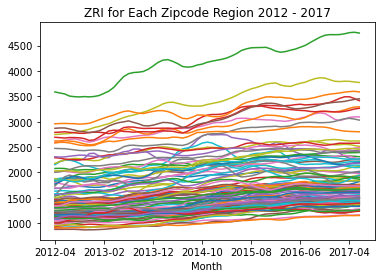

In [42]:
#plot ZRI 
plt.figure(figsize=(3.841, 7.195), dpi=100)
transposed_ZRI_2012.plot(kind='line', x = 'Month', title='ZRI for Each Zipcode Region 2012 - 2017',legend=False)
plt.show()
# plt.savefig('ZRI for Each Zipcode Region 2012 - 2017.png', dpi=2000)

In [43]:
#store in dictionary by zipcode for later use when doing the hypothesis test 
ZRI_by_zipcode = {}
for zipcode in list(transposed_ZRI_2012.columns[:-1]):
    ZRI_by_zipcode[zipcode] = transposed_ZRI_2012[[zipcode, "Month"]]

In [44]:
#check point: 
# transposed_ZRI_2012.to_csv(filepath + "transposed_ZRI_from_2012.csv")

## Demographics

In [45]:
## load and clean 2011-2015 demographics data ##
df_demo = pd.read_csv("demographics.csv", header=None)

#define column name
df_demo.columns = df_demo.iloc[0]
df_demo = df_demo.drop(df_demo.index[0])

#drop any row with "-" cell in income column
df_demo = df_demo[df_demo["$9,999_or_less"] != "-"]

col_income_pct = ["$9,999_or_less", "$10,000-$14,999", "$15,000-$24,999", "$25,000-$34,999", 
                  "$35,000-$49,999", "$50,000-$64,999", "$65,000-$74,999", "$75,000_or_more"]
df_demo[col_income_pct] = df_demo[col_income_pct].astype(float)

#drop any rows has negative value
df_demo = df_demo[df_demo.select_dtypes(include=[np.number]).ge(0).all(1)] 
df_demo = df_demo.reset_index(drop=True)
df_demo

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,zipcode,population,5_years_or_less,5-9_years,10-14_years,15-19_years,20-24_years,25-34_years,35-44_years,45-54_years,...,"$9,999_or_less","$10,000-$14,999","$15,000-$24,999","$25,000-$34,999","$35,000-$49,999","$50,000-$64,999","$65,000-$74,999","$75,000_or_more",median_household_income,mean_household_income
0,601,17982,1006,1080,1342,1352,1321,2253,2149,2434,...,48.1,12.0,12.8,8.6,8.7,6.2,1.4,2.2,10816,20349
1,602,40260,2006,2440,2421,2953,2865,5124,5139,5947,...,31.4,16.3,17.9,12.2,10.6,7.7,2.9,1.0,16079,23282
2,603,52408,2664,3177,3351,3685,3585,6473,6775,6678,...,31.0,14.9,17.5,11.7,10.8,8.7,2.4,3.0,16804,26820
3,606,6331,347,331,461,474,469,707,933,776,...,45.3,10.2,20.0,11.7,11.0,1.8,0.0,0.0,12512,15730
4,610,28328,1438,1490,2044,2122,1985,3358,3778,3858,...,26.9,14.8,23.7,15.2,9.3,7.5,1.6,1.0,17475,23360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32288,99923,13,0,0,0,0,0,0,0,0,...,0.0,46.2,53.8,0.0,0.0,0.0,0.0,0.0,-,N
32289,99925,826,65,50,47,36,60,86,82,111,...,7.1,6.2,21.2,11.1,12.6,17.5,9.5,14.8,38594,52706
32290,99926,1711,161,124,140,113,107,224,182,236,...,5.5,1.9,14.1,11.1,16.8,14.5,12.0,24.1,51071,71580
32291,99927,123,0,0,0,0,0,0,32,22,...,28.2,0.0,23.1,15.4,25.6,0.0,0.0,7.7,19861,35617


In [46]:
## function for computing gini coefficient ##
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [47]:
df_demo['Gini_Coef'] = np.nan

#calculate gini coeffcient for each zipcode 2011-2015
for idx, row in df_demo.iterrows():
  arr = df_demo[col_income_pct].loc[idx].to_numpy()
  gini_coef = gini(arr)
  df_demo.loc[idx,'Gini_Coef'] = gini_coef

df_demo

,zipcode,population,5_years_or_less,5-9_years,10-14_years,15-19_years,20-24_years,25-34_years,35-44_years,45-54_years,...,"$10,000-$14,999","$15,000-$24,999","$25,000-$34,999","$35,000-$49,999","$50,000-$64,999","$65,000-$74,999","$75,000_or_more",median_household_income,mean_household_income,Gini_Coef
0,601,17982,1006,1080,1342,1352,1321,2253,2149,2434,...,12.0,12.8,8.6,8.7,6.2,1.4,2.2,10816,20349,0.49675
1,602,40260,2006,2440,2421,2953,2865,5124,5139,5947,...,16.3,17.9,12.2,10.6,7.7,2.9,1.0,16079,23282,0.39400
2,603,52408,2664,3177,3351,3685,3585,6473,6775,6678,...,14.9,17.5,11.7,10.8,8.7,2.4,3.0,16804,26820,0.36525
3,606,6331,347,331,461,474,469,707,933,776,...,10.2,20.0,11.7,11.0,1.8,0.0,0.0,12512,15730,0.55950
4,610,28328,1438,1490,2044,2122,1985,3358,3778,3858,...,14.8,23.7,15.2,9.3,7.5,1.6,1.0,17475,23360,0.40050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32288,99923,13,0,0,0,0,0,0,0,0,...,46.2,53.8,0.0,0.0,0.0,0.0,0.0,-,N,0.75950
32289,99925,826,65,50,47,36,60,86,82,111,...,6.2,21.2,11.1,12.6,17.5,9.5,14.8,38594,52706,0.21800
32290,99926,1711,161,124,140,113,107,224,182,236,...,1.9,14.1,11.1,16.8,14.5,12.0,24.1,51071,71580,0.28025
32291,99927,123,0,0,0,0,0,0,32,22,...,0.0,23.1,15.4,25.6,0.0,0.0,7.7,19861,35617,0.50300


In [48]:
NC_zip = [str(x) for x in list(range(27006, 28909))]
TX_zip = [str(x) for x in list(range(73301, 88595))]
TN_zip = [str(x) for x in list(range(37010, 38589))]
LA_zip = [str(x) for x in list(range(70001, 71497))]

In [49]:
df_demo_NC = df_demo[df_demo.zipcode.isin(NC_zip)]
df_demo_TX = df_demo[df_demo.zipcode.isin(TX_zip)]
df_demo_TN = df_demo[df_demo.zipcode.isin(TN_zip)]
df_demo_LA = df_demo[df_demo.zipcode.isin(LA_zip)]

In [50]:
## Plot Gini Coefficient for 4 States 2011-2015 ##
map_NC = folium.Map(location=[35.55, -82.60], zoom_start=10)

folium.Choropleth(geo_data="nc_zip_codes.json",
             data = df_demo_NC, # my dataset
             columns=['zipcode', 'Gini_Coef'], # zip code is here for matching the geojson zipcode
             key_on='feature.properties.ZCTA5CE10', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.5,
             legend_name='Gini Coefficient').add_to(map_NC)

folium.LayerControl().add_to(map_NC)

In [51]:
for idx, row in sub2.iterrows():
    latitute = float(sub2.loc[idx, 'latitude'])
    longitude = float(sub2.loc[idx, 'longitude'])
    folium.Marker(
        location=[latitute, longitude],
        popup="Timberline Lodge",
        icon=folium.Icon(color="green")).add_to(map_NC)

In [52]:
#save the map as .html file
map_NC.save("map_NC.html")

In [53]:
map_TX = folium.Map(location=[30.325,  -97.777], zoom_start=10)

folium.Choropleth(geo_data="tx_zip_codes.json",
                  data = df_demo_TX, # my dataset
                  columns=['zipcode', 'Gini_Coef'], # zip code is here for matching the geojson zipcode
                  key_on='feature.properties.ZCTA5CE10', 
                  fill_color='BuPu', fill_opacity=0.7, line_opacity=0.5,
                  legend_name = "Gini Coefficient").add_to(map_TX)

folium.LayerControl().add_to(map_TX)

In [54]:
for idx, row in sub3.iterrows():
    latitute = float(sub3.loc[idx, 'latitude'])
    longitude = float(sub3.loc[idx, 'longitude'])
    folium.Marker(
        location=[latitute, longitude],
        popup="Timberline Lodge",
        icon=folium.Icon(color="green")).add_to(map_TX)

In [55]:
#save the map as .html file
map_TX.save("map_TX.html")

In [56]:
map_TN = folium.Map(location=[36.175, -86.79], zoom_start=10)

folium.Choropleth(geo_data="tn_zip_codes.json",
             data = df_demo_TN, # my dataset
             columns=['zipcode', 'Gini_Coef'], # zip code is here for matching the geojson zipcode
             key_on='feature.properties.ZCTA5CE10', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.5,
             legend_name='Gini Coefficient').add_to(map_TN)

folium.LayerControl().add_to(map_TN)

In [57]:
for idx, row in sub4.iterrows():
    latitute = float(sub4.loc[idx, 'latitude'])
    longitude = float(sub4.loc[idx, 'longitude'])
    folium.Marker(
        location=[latitute, longitude],
        popup="Timberline Lodge",
        icon=folium.Icon(color="green")).add_to(map_TN)

In [58]:
#save the map as .html file
map_TN.save("map_TN.html")

In [59]:
map_LA = folium.Map(location=[30.01, -89.94], zoom_start=10)

folium.Choropleth(geo_data="la_zip_codes.json",
             data = df_demo_LA, # my dataset
             columns=['zipcode', 'Gini_Coef'], # zip code is here for matching the geojson zipcode
             key_on='feature.properties.ZCTA5CE10', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.5,
             legend_name='Gini Coefficient').add_to(map_LA)

folium.LayerControl().add_to(map_LA)

In [60]:
for idx, row in sub5.iterrows():
    latitute = float(sub5.loc[idx, 'latitude'])
    longitude = float(sub5.loc[idx, 'longitude'])
    folium.Marker(
        location=[latitute, longitude],
        popup="Timberline Lodge",
        icon=folium.Icon(color="green")).add_to(map_LA)

In [61]:
#save the map as .html file
map_LA.save("map_LA.html")

# Modelling

In [62]:
from semopy import Model

In [63]:
#load ZRI data set and compute average
df_zri = ZRI_in_listing_area_from_2012
df_zri.dtypes

type       string
zipcode    object
city       string
state      string
metro      string
            ...  
2017-02     int64
2017-03     int64
2017-04     int64
2017-05     int64
2017-06     int64
Length: 70, dtype: object

In [64]:
zipcode = df_list.zipcode.unique()
df_demo_list = df_demo[df_demo.zipcode.isin(zipcode)]

In [65]:
# average zri by zipcode from 2012-2017
df_zri["avg_zri"] = df_zri.loc[:, "2012-04":"2017-06"].astype(float).mean(axis=1)
avg_zri = df_zri[['zipcode', 'avg_zri']]

#number of listing by zip code
num_list = df_list.groupby('zipcode').size().reset_index(name='num_list')

#average price by zip code
avg_price = df_list.groupby('zipcode')['price'].mean().reset_index(name='avg_price')

#number of households by zipcode
households = df_demo_list[['zipcode', 'households']].reset_index(drop=True)

#mean household income by zipcode in log
mean_household_income = df_demo_list[['zipcode', 'mean_household_income']].reset_index(drop=True)

#gini coef in 2015 by zipcode
gini = df_demo_list[['zipcode', 'Gini_Coef']].reset_index(drop=True)

<ipython-input-65-b15b4b25f203>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zri["avg_zri"] = df_zri.loc[:, "2012-04":"2017-06"].astype(float).mean(axis=1)


In [66]:
#merge dataframes by zipcode
df = [avg_price, households, avg_zri, mean_household_income, gini]

data = num_list.astype(float)

for x in df:
  x = x.astype(float)
  data = pd.merge(data, x, on=['zipcode'])

data = data.drop(columns=["zipcode"])
data = data.astype(float)
data

,num_list,avg_price,households,avg_zri,mean_household_income,Gini_Coef
0,30.0,96.433333,8154.0,1317.158730,77643.0,0.32025
1,29.0,88.586207,9971.0,1242.238095,62403.0,0.16925
2,24.0,148.916667,6965.0,1318.349206,62197.0,0.27975
3,1.0,140.000000,2740.0,1328.793651,71846.0,0.32350
4,2.0,55.000000,7808.0,1348.015873,63535.0,0.23625
...,...,...,...,...,...,...
102,72.0,147.777778,7171.0,1485.158730,72114.0,0.31800
103,131.0,232.183206,4408.0,2120.111111,93646.0,0.38950
104,196.0,175.005102,10591.0,1825.666667,81900.0,0.32150
105,133.0,158.390977,18447.0,1424.603175,58034.0,0.19125


In [67]:
x = data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data = pd.DataFrame(x_scaled)
col = ['num_listings', 'avg_price', 'num_households', 'avg_ZRI',
       'mean_income', 'gini_coef']
data.columns=col
data

,num_listings,avg_price,num_households,avg_ZRI,mean_income,gini_coef
0,0.014617,0.084986,0.230392,0.096822,0.251290,0.377021
1,0.014113,0.075381,0.286410,0.073093,0.161814,0.120000
2,0.011593,0.149225,0.193735,0.097199,0.160605,0.308085
3,0.000000,0.138311,0.063479,0.100507,0.217255,0.382553
4,0.000504,0.034272,0.219725,0.106595,0.168460,0.234043
...,...,...,...,...,...,...
102,0.035786,0.147831,0.200086,0.150032,0.218829,0.373191
103,0.065524,0.251142,0.114903,0.351137,0.345246,0.494894
104,0.098286,0.181157,0.305525,0.257879,0.276284,0.379149
105,0.066532,0.160821,0.547725,0.130852,0.136163,0.157447


In [68]:
mod = """ 
          income_inequality =~ gini_coef
          airbnb_activity =~ num_listings + avg_price
          rental_price =~ income_inequality
          rental_price ~ mean_income + airbnb_activity
          airbnb_activity ~ num_households + avg_ZRI + mean_income 
          income_inequality ~ airbnb_activity
      """

model = Model(mod)

In [71]:
model.fit(data)
from semopy import Optimizer
opt = Optimizer(model)
objective_function_value = opt.optimize()
model.inspect()
#g = semopy.semplot(model, "pd.png")
#print(semopy.efa.explore_cfa_model(data))

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,income_inequality,~,rental_price,1.000000e+00,-,-,-
1,rental_price,~,mean_income,1.071486e+00,0.0620952,17.2555,0
2,rental_price,~,airbnb_activity,-3.183091e-01,0.114823,-2.77218,0.00556823
3,airbnb_activity,~,num_households,4.525927e-02,0.0419839,1.07801,0.281028
4,airbnb_activity,~,avg_ZRI,7.175194e-01,0.144923,4.95102,7.38244e-07
5,airbnb_activity,~,mean_income,-4.073417e-01,0.106105,-3.83905,0.000123512
6,income_inequality,~,airbnb_activity,-3.183091e-01,0.114823,-2.77218,0.00556823
7,gini_coef,~,income_inequality,1.000000e+00,-,-,-
8,num_listings,~,airbnb_activity,1.000000e+00,-,-,-
9,avg_price,~,airbnb_activity,1.161842e+00,0.295824,3.92748,8.58409e-05


In [72]:
model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,income_inequality,~,rental_price,1.000000e+00,-,-,-
1,rental_price,~,mean_income,1.071486e+00,0.0620952,17.2555,0
2,rental_price,~,airbnb_activity,-3.183091e-01,0.114823,-2.77218,0.00556823
3,airbnb_activity,~,num_households,4.525927e-02,0.0419839,1.07801,0.281028
4,airbnb_activity,~,avg_ZRI,7.175194e-01,0.144923,4.95102,7.38244e-07
5,airbnb_activity,~,mean_income,-4.073417e-01,0.106105,-3.83905,0.000123512
6,income_inequality,~,airbnb_activity,-3.183091e-01,0.114823,-2.77218,0.00556823
7,gini_coef,~,income_inequality,1.000000e+00,-,-,-
8,num_listings,~,airbnb_activity,1.000000e+00,-,-,-
9,avg_price,~,airbnb_activity,1.161842e+00,0.295824,3.92748,8.58409e-05


In [73]:
print(mod)

 
          income_inequality =~ gini_coef
          airbnb_activity =~ num_listings + avg_price
          rental_price =~ income_inequality
          rental_price ~ mean_income + airbnb_activity
          airbnb_activity ~ num_households + avg_ZRI + mean_income 
          income_inequality ~ airbnb_activity
      


# Airbnb Listing Price Index

In [74]:
listing_data = cleaned_southern_df_listings
listing_data_by_month = cleaned_merged_calendar_listing
print(listing_data_by_month)

         accommodates                                          amenities  \
0                   2  {"Wireless Internet","Air Conditioning",Kitche...   
1                   2  {"Wireless Internet","Air Conditioning",Kitche...   
2                   2  {"Wireless Internet","Air Conditioning",Kitche...   
3                   2  {"Wireless Internet","Air Conditioning",Kitche...   
4                   2  {"Wireless Internet","Air Conditioning",Kitche...   
...               ...                                                ...   
3541803             2                                                 {}   
3541804             2                                                 {}   
3541805             2                                                 {}   
3541806             2                                                 {}   
3541807             2                                                 {}   

         availability_30  bathrooms  bed_type  bedrooms  beds  \
0                     

In [75]:
zipcode_data = listing_data[['zipcode']]
price_data = listing_data[['price']]

pricesPerZip = {}
numPerZip = {}

for i in range(zipcode_data.shape[0]):
  currZip = zipcode_data.iloc[i][0]
  
  if(currZip is NaN):
    continue
  if(currZip == 701115):
    currZip = 70115
  if currZip in pricesPerZip:
    pricesPerZip[currZip].append(float(price_data.iloc[i][0]))
    numPerZip[currZip] += 1
  else:
    pricesPerZip[currZip] = [float(price_data.iloc[i][0])]
    numPerZip[currZip] = 1

listing_data_by_month['date'] = listing_data_by_month['date'].astype('str')

zipcode_data_monthly = listing_data_by_month[['zipcode']]
price_data_monthly = listing_data_by_month[['price_from_calendar']]
date_column = listing_data_by_month[['date']]

pricesPerZipMonthly = {}
numPerZipMonthly = {}

for i in range(zipcode_data_monthly.shape[0]):
  currZip = zipcode_data_monthly.iloc[i][0]
  currDate = date_column.iloc[i][0][0:7]

  if(currZip is NaN):
    continue
  if(currZip == 701115):
    currZip = 70115
  if currZip in pricesPerZipMonthly:
    if currDate in pricesPerZipMonthly[currZip]:
      pricesPerZipMonthly[currZip][currDate].append(float(price_data_monthly.iloc[i][0]))
      numPerZipMonthly[currZip][currDate] += 1
    else:
      pricesPerZipMonthly[currZip][currDate] = [float(price_data_monthly.iloc[i][0])]
      numPerZipMonthly[currZip][currDate] = 1
  else:
    pricesPerZipMonthly[currZip] = {currDate : [float(price_data_monthly.iloc[i][0])]}
    numPerZipMonthly[currZip] = {currDate : 1} 

In [76]:
priceStats = pd.DataFrame()

for i in (sorted(pricesPerZip)):
  prices = pricesPerZip[i]
  priceStats = priceStats.append([[i, numPerZip[i], statistics.median(prices), round(statistics.mean(prices),1)]])

priceStats = priceStats.rename(columns = {0:'zipcode', 1:'Number of Listings', 2:'Median Price', 3:'Mean Price'})
print(priceStats)

   zipcode  Number of Listings  Median Price  Mean Price
0    28704                  30          77.5        96.4
0    28715                  29          75.0        88.6
0    28732                  24          97.5       148.9
0    28759                   1         140.0       140.0
0    28787                   2          55.0        55.0
..     ...                 ...           ...         ...
0    78757                 196         125.0       175.0
0    78758                 133          97.0       158.4
0    78759                 113         100.0       167.7
0    78774                   1          75.0        75.0
0    90706                   1         154.0       154.0

[117 rows x 4 columns]


In [77]:
months = ['2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06']

monthlyPriceStats = pd.DataFrame()

differences = []

for i in (sorted(pricesPerZipMonthly)):
  currRow = [i]
  #currRow = []
  prevMonth = 0
  for j in months:
    if j in pricesPerZipMonthly[i]:
      currRow.append((np.percentile(pricesPerZipMonthly[i][j],20)+np.percentile(pricesPerZipMonthly[i][j],80))/2)
      
    else:
      currRow.append(NaN)
      
  monthlyPriceStats = monthlyPriceStats.append([currRow])

columnLabels = {0 : "zipcode"}
for i in range(len(months)):
  columnLabels[i+1] = (months[i]+" Mean Price (20th to 80th)")

monthlyPriceStats = monthlyPriceStats.rename(columns = columnLabels)

#monthlyPriceStats.to_csv(data_dir + "airbnb_listing_price_index_with_mean_20_to_80.csv")

# Perform Granger Causality Tests for ALPI and ZRI Time Series

In [78]:
#load or assign ALPI using the ALPI calculated from last section --> check for 116 rows × 28 columns
# ALPI = pd.read_csv("{}/airbnb_listing_price_index_with_mean_20_to_80.csv".format(data_dir), index_col = 0)
ALPI = monthlyPriceStats
ALPI.columns = ['zipcode', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06']
ALPI

,zipcode,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
0,28704,76.5,75.0,76.0,82.5,82.5,82.5,82.5,82.5,82.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,28715,102.0,92.5,92.5,87.5,87.5,87.5,92.5,87.5,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,28732,212.5,185.0,149.5,171.5,177.5,177.5,177.5,176.0,177.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,28759,140.0,140.0,140.0,NaN,144.0,143.0,140.0,145.0,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,28787,32.0,49.0,50.0,54.7,80.5,82.5,82.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,78757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,187.5,216.5,190.0,196.0,177.5,182.0,189.5,NaN,NaN,NaN
0,78758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,138.0,161.0,138.0,138.5,133.7,130.5,126.0,NaN,NaN,NaN
0,78759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,153.0,167.5,154.5,155.5,135.0,129.9,146.0,NaN,NaN,NaN
0,78774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.5,80.0,80.0,80.0,80.0,80.0,80.0,NaN,NaN,NaN


In [79]:
#transpose and cast --> check for 27 rows × 117 columns
transposed_ALPI = ALPI
transposed_ALPI['zipcode'] = transposed_ALPI['zipcode'].astype("str")
transposed_ALPI = transposed_ALPI.set_index('zipcode').T
transposed_ALPI['Month'] = transposed_ALPI.index
transposed_ALPI = transposed_ALPI.reset_index(drop=True)
transposed_ALPI.Month = transposed_ALPI.Month.astype('datetime64[ns]')
transposed_ALPI

zipcode,28704,28715,28732,28759,28787,28801,28803,28804,28805,28806,...,78752,78753,78754,78756,78757,78758,78759,78774,90706,Month
0,76.5,102.0,212.5,140.0,32.0,146.0,120.5,122.5,107.0,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-01
1,75.0,92.5,185.0,140.0,49.0,146.5,117.5,122.5,107.5,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-01
2,76.0,92.5,149.5,140.0,50.0,146.0,120.0,127.0,119.5,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-01
3,82.5,87.5,171.5,NaN,54.7,155.0,120.0,125.0,120.0,105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
4,82.5,87.5,177.5,144.0,80.5,150.5,120.0,119.5,122.5,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-01
5,82.5,87.5,177.5,143.0,82.5,155.0,125.0,120.0,124.5,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-01
6,82.5,92.5,177.5,140.0,82.5,165.0,130.0,126.0,120.0,103.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-01
7,82.5,87.5,176.0,145.0,NaN,167.5,122.5,127.5,122.5,107.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-01
8,82.5,87.0,177.5,150.0,NaN,164.0,122.5,127.2,122.5,107.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-01
9,80.0,87.0,177.5,140.0,NaN,152.0,120.0,125.0,122.0,105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01


<Figure size 384.1x719.5 with 0 Axes>

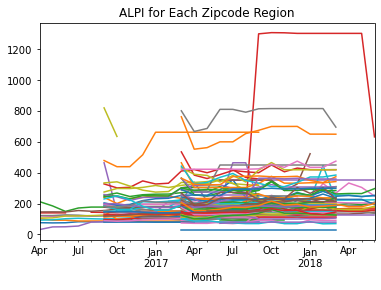

In [80]:
#Plot
plt.figure(figsize=(3.841, 7.195), dpi=100)
transposed_ALPI.plot(kind='line', x = 'Month', title='ALPI for Each Zipcode Region',legend=False)
plt.show()

In [81]:
#store in dictionary by zipcode for use in hypothesis test
ALPI_by_zipcode = {}
for zipcode in list(transposed_ALPI.columns[:-1]):
    ALPI_by_zipcode[zipcode] = transposed_ALPI[[zipcode, "Month"]]

## Start Granger Causality Tests for Two Time Series
Notes: minimum observations of time series is 5 samples

In [82]:
#helper function 
def get_overlaped_period_data(ZRI, ALPI):
    df_to_return = pd.DataFrame()
    ZRI.Month = ZRI.Month.astype('datetime64[ns]')
    ALPI.Month = ALPI.Month.astype('datetime64[ns]')
    non_NA_ALPI = ALPI.dropna()
    non_NA_ALPI = non_NA_ALPI.reset_index(drop=True)
    ZRI_overlaped = ZRI[ZRI.Month.isin(non_NA_ALPI.Month)]
    ZRI_overlaped = ZRI_overlaped.reset_index(drop=True)
    df_to_return['Month'] = ZRI_overlaped.Month
    df_to_return['ZRI'] = ZRI_overlaped.iloc[:, [0]]
    df_to_return['ALPI'] = non_NA_ALPI.iloc[:, [0]]
    return df_to_return

In [83]:
#try to see if zipcode is different in the ALPI and ZRI, get the zipcodes that appreared in both dataset
over_lapped_cols = []
non_over_lapped_cols = []
for col in list(transposed_ALPI.columns):
    if col in list(transposed_ZRI_2012.columns):
        over_lapped_cols.append(col)
    else:
        non_over_lapped_cols.append(col)
# print(over_lapped_cols)
print(non_over_lapped_cols)
#varified that the non overlapped cols are not in ZRI provided in the original dataset 

['37228', '70111', '70112', '70113', '70148', '78719', '78742', '78774', '90706']


In [84]:
#Start the test!!!
zip_code_with_constant_values = []
zip_code_with_not_enough_observations = []
granger_causality_test_results = {}
#dont wanna do test on the 'month' coloumn so dont include it when looping the dataframe 
over_lapped_col = over_lapped_cols[:-1]
counter = 0
for zipcode in over_lapped_col:
    print("At: ", counter)
    print("Analyzing zipcode: ", zipcode)
    ZRI_for_area = ZRI_by_zipcode.get(str(zipcode))
    ALPI_for_area = ALPI_by_zipcode.get(str(zipcode))
    df_ZRI_ALPI = get_overlaped_period_data(ZRI_for_area, ALPI_for_area)
    df_ZRI_ALPI = df_ZRI_ALPI[['ZRI', 'ALPI']]
    # break
    if len(df_ZRI_ALPI) <= 4:
        print("Zipcode: ", zipcode, " does not have enough observations.")
        zip_code_with_not_enough_observations.append(zipcode)
        counter += 1
        continue 
    else:
        print("Zipcode: ", zipcode, " has enough observations, will try to perform test.")
        try:
            addconst = True
            max_lag_allowed = int((df_ZRI_ALPI.shape[0] - int(addconst)) / 3) - 1
            print("Zipcode: ", zipcode, " is testing is max lag: ", max_lag_allowed)
            test_results = grangercausalitytests(df_ZRI_ALPI, max_lag_allowed, addconst = True, verbose = True)
            print("Finished testing, saving the test results...")
            granger_causality_test_results[zipcode] = test_results
            print("Test result for zipcode : ", zipcode, " is saved.")
            counter += 1
        except:
            print("Zipcode: ", zipcode, " has failed to perform the test, saving the zipcode for investigation later.")
            zip_code_with_constant_values.append(zipcode)
            counter += 1
            continue

At:  0
Analyzing zipcode:  28704
Zipcode:  28704  has enough observations, will try to perform test.
Zipcode:  28704  is testing is max lag:  3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6580  , p=0.0218  , df_denom=9, df_num=1
ssr based chi2 test:   chi2=10.2107 , p=0.0014  , df=1
likelihood ratio test: chi2=7.3880  , p=0.0066  , df=1
parameter F test:         F=7.6580  , p=0.0218  , df_denom=9, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6536  , p=0.0917  , df_denom=6, df_num=2
ssr based chi2 test:   chi2=13.3964 , p=0.0012  , df=2
likelihood ratio test: chi2=8.7619  , p=0.0125  , df=2
parameter F test:         F=3.6536  , p=0.0917  , df_denom=6, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3997  , p=0.3945  , df_denom=3, df_num=3
ssr based chi2 test:   chi2=13.9966 , p=0.0029  , df=3
likelihood ratio test: chi2=8.7533  , p=0.0328  , df=3
parameter F test:         F=1.399

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

ssr based F test:         F=2.8200  , p=0.1370  , df_denom=6, df_num=2
ssr based chi2 test:   chi2=10.3401 , p=0.0057  , df=2
likelihood ratio test: chi2=7.2896  , p=0.0261  , df=2
parameter F test:         F=2.8200  , p=0.1370  , df_denom=6, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2528  , p=0.4287  , df_denom=3, df_num=3
ssr based chi2 test:   chi2=12.5280 , p=0.0058  , df=3
likelihood ratio test: chi2=8.1217  , p=0.0436  , df=3
parameter F test:         F=1.2528  , p=0.4287  , df_denom=3, df_num=3
Finished testing, saving the test results...
Test result for zipcode :  28806  is saved.
At:  10
Analyzing zipcode:  37013
Zipcode:  37013  has enough observations, will try to perform test.
Zipcode:  37013  is testing is max lag:  2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5665  , p=0.2573  , df_denom=6, df_num=1
ssr based chi2 test:   chi2=2.3498  , p=0.1253  , df=1
likelihood ratio test: chi2=2.0878  , p=0.14

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

ssr based F test:         F=0.2547  , p=0.7904  , df_denom=3, df_num=2
ssr based chi2 test:   chi2=1.3583  , p=0.5071  , df=2
likelihood ratio test: chi2=1.2546  , p=0.5340  , df=2
parameter F test:         F=0.2547  , p=0.7904  , df_denom=3, df_num=2
Finished testing, saving the test results...
Test result for zipcode :  37189  is saved.
At:  22
Analyzing zipcode:  37201
Zipcode:  37201  has enough observations, will try to perform test.
Zipcode:  37201  is testing is max lag:  2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1047  , p=0.3337  , df_denom=6, df_num=1
ssr based chi2 test:   chi2=1.6571  , p=0.1980  , df=1
likelihood ratio test: chi2=1.5210  , p=0.2175  , df=1
parameter F test:         F=1.1047  , p=0.3337  , df_denom=6, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8276  , p=0.5173  , df_denom=3, df_num=2
ssr based chi2 test:   chi2=4.4139  , p=0.1100  , df=2
likelihood ratio test: chi2=3.5150  , p=0.17

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

ssr based F test:         F=0.0551  , p=0.9473  , df_denom=3, df_num=2
ssr based chi2 test:   chi2=0.2938  , p=0.8634  , df=2
likelihood ratio test: chi2=0.2885  , p=0.8657  , df=2
parameter F test:         F=0.0551  , p=0.9473  , df_denom=3, df_num=2
Finished testing, saving the test results...
Test result for zipcode :  37214  is saved.
At:  34
Analyzing zipcode:  37215
Zipcode:  37215  has enough observations, will try to perform test.
Zipcode:  37215  is testing is max lag:  2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9596  , p=0.0937  , df_denom=6, df_num=1
ssr based chi2 test:   chi2=5.9394  , p=0.0148  , df=1
likelihood ratio test: chi2=4.5610  , p=0.0327  , df=1
parameter F test:         F=3.9596  , p=0.0937  , df_denom=6, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=22.0375 , p=0.0161  , df_denom=3, df_num=2
ssr based chi2 test:   chi2=117.5332, p=0.0000  , df=2
likelihood ratio test: chi2=22.0250 , p=0.00

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Zipcode:  70126  does not have enough observations.
At:  55
Analyzing zipcode:  70127
Zipcode:  70127  does not have enough observations.
At:  56
Analyzing zipcode:  70128
Zipcode:  70128  does not have enough observations.
At:  57
Analyzing zipcode:  70129
Zipcode:  70129  does not have enough observations.
At:  58
Analyzing zipcode:  70130
Zipcode:  70130  does not have enough observations.
At:  59
Analyzing zipcode:  70131
Zipcode:  70131  does not have enough observations.
At:  60
Analyzing zipcode:  70461
Zipcode:  70461  does not have enough observations.
At:  61
Analyzing zipcode:  78218
Zipcode:  78218  does not have enough observations.
At:  62
Analyzing zipcode:  78617
Zipcode:  78617  does not have enough observations.
At:  63
Analyzing zipcode:  78620
Zipcode:  78620  does not have enough observations.
At:  64
Analyzing zipcode:  78644
Zipcode:  78644  does not have enough observations.
At:  65
Analyzing zipcode:  78652
Zipcode:  78652  does not have enough observations.
At

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

 78741  does not have enough observations.
At:  92
Analyzing zipcode:  78744
Zipcode:  78744  does not have enough observations.
At:  93
Analyzing zipcode:  78745
Zipcode:  78745  does not have enough observations.
At:  94
Analyzing zipcode:  78746
Zipcode:  78746  does not have enough observations.
At:  95
Analyzing zipcode:  78747
Zipcode:  78747  does not have enough observations.
At:  96
Analyzing zipcode:  78748
Zipcode:  78748  does not have enough observations.
At:  97
Analyzing zipcode:  78749
Zipcode:  78749  does not have enough observations.
At:  98
Analyzing zipcode:  78750
Zipcode:  78750  does not have enough observations.
At:  99
Analyzing zipcode:  78751
Zipcode:  78751  does not have enough observations.
At:  100
Analyzing zipcode:  78752
Zipcode:  78752  does not have enough observations.
At:  101
Analyzing zipcode:  78753
Zipcode:  78753  does not have enough observations.
At:  102
Analyzing zipcode:  78754
Zipcode:  78754  does not have enough observations.
At:  103

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

## Looing at the results

In [85]:
# Looking at how many zipcodes does not have enough observation, how many zipcode has problem with the test
print("Number of zipcode areas do not have enough observation: ", len(zip_code_with_not_enough_observations))
print("Number of zipcode areas can not perform the test: ", len(zip_code_with_constant_values))
print("Number of zipcode areas performed the test: ", len(granger_causality_test_results))

Number of zipcode areas do not have enough observation:  67
Number of zipcode areas can not perform the test:  1
Number of zipcode areas performed the test:  39


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<Figure size 384.1x719.5 with 0 Axes>

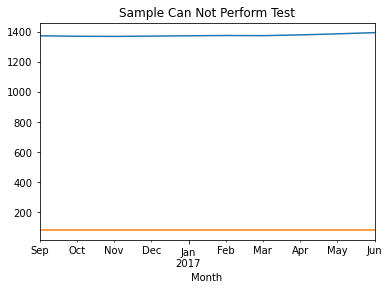

,Month,ZRI,ALPI
0,2016-09-01,1374.0,80.0
1,2016-10-01,1371.0,80.0
2,2016-11-01,1370.0,80.0
3,2016-12-01,1372.0,80.0
4,2017-01-01,1374.0,80.0
5,2017-02-01,1376.0,80.0
6,2017-03-01,1375.0,80.0
7,2017-04-01,1380.0,80.0
8,2017-05-01,1387.0,80.0
9,2017-06-01,1395.0,80.0


In [86]:
#Investigate why the one failed to perform a test
ZRI_to_investigate = ZRI_by_zipcode.get(str(zip_code_with_constant_values[0]))
ALPI_to_investigate = ALPI_by_zipcode.get(str(zip_code_with_constant_values[0]))
df_ZRI_ALPI_to_investigate = get_overlaped_period_data(ZRI_to_investigate, ALPI_to_investigate)
df_ZRI_ALPI_to_investigate
plt.figure(figsize=(3.841, 7.195), dpi=100)
df_ZRI_ALPI_to_investigate.plot(kind='line', x = 'Month', title='Sample Can Not Perform Test',legend=False)
plt.show()
df_ZRI_ALPI_to_investigate
#Conclusion: as we can see, the ALPI from 2016.09 to 2017.06 is constant

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

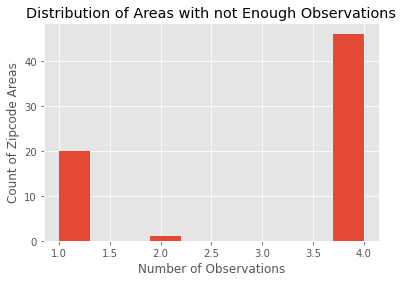

In [87]:
#Investigate the 67 zipcode areas with not enough observation 
count_for_observation = []
for zipcode in zip_code_with_not_enough_observations:
    ZRI_to_investigate = ZRI_by_zipcode.get(str(zipcode))
    ALPI_to_investigate = ALPI_by_zipcode.get(str(zipcode))
    df_ZRI_ALPI_to_investigate = get_overlaped_period_data(ZRI_to_investigate, ALPI_to_investigate)
    count_for_observation.append(len(df_ZRI_ALPI_to_investigate))

plt.style.use('ggplot')
plt.hist(count_for_observation, bins = 10)
plt.xlabel('Number of Observations')
plt.ylabel('Count of Zipcode Areas')
plt.title('Distribution of Areas with not Enough Observations')
plt.show()

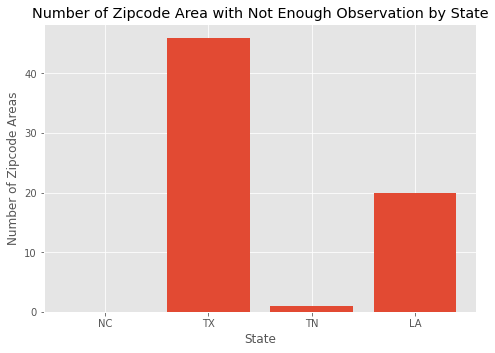

In [88]:
#looking at the distrubution of not enough sample zipcode by state
state_data_to_check = ZRI_in_listing_area_from_2012[ZRI_in_listing_area_from_2012.zipcode.isin(zip_code_with_not_enough_observations)]
not_enought_sample_NC = len(state_data_to_check[state_data_to_check.state == 'NC'])
not_enought_sample_TX = len(state_data_to_check[state_data_to_check.state == 'TX'])
not_enought_sample_TN = len(state_data_to_check[state_data_to_check.state == 'TN'])
not_enought_sample_LA = len(state_data_to_check[state_data_to_check.state == 'LA'])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
states = ["NC", "TX", "TN", "LA"]
number_of_areas = [not_enought_sample_NC, not_enought_sample_TX, not_enought_sample_TN, not_enought_sample_LA]
ax.bar(states,number_of_areas)
plt.xlabel('State')
plt.ylabel('Number of Zipcode Areas')
plt.title('Number of Zipcode Area with Not Enough Observation by State')
plt.show()
#conclusion: most of them are in TX and LA

## Start looking at the test results for the 39 zipcode areas

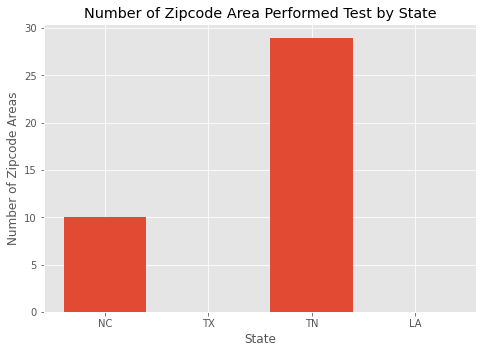

In [89]:
#looking at the distrubution of tested sample zipcode by state
state_data_to_check = ZRI_in_listing_area_from_2012[ZRI_in_listing_area_from_2012.zipcode.isin(granger_causality_test_results.keys())]
tested_sample_NC = len(state_data_to_check[state_data_to_check.state == 'NC'])
tested_sample_TX = len(state_data_to_check[state_data_to_check.state == 'TX'])
tested_sample_TN = len(state_data_to_check[state_data_to_check.state == 'TN'])
tested_sample_LA = len(state_data_to_check[state_data_to_check.state == 'LA'])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
states = ["NC", "TX", "TN", "LA"]
number_of_areas = [tested_sample_NC, tested_sample_TX, tested_sample_TN, tested_sample_LA]
ax.bar(states,number_of_areas)
plt.xlabel('State')
plt.ylabel('Number of Zipcode Areas')
plt.title('Number of Zipcode Area Performed Test by State')
plt.show()

In [90]:
#example to get p-value
#zipcode --> lag --> first element (stats test) --> test name --> p value is the second element  
# granger_causality_test_results.get('28704').get(1)[0].get('ssr_ftest')[1]

In [91]:
#set up a dataframe for p-value information
p_value_result_col = ['Zipcode', 'Lag', 'P_value_ssr_ftest', 'P_value_ssr_chi2test', 'P_value_lrtest', 'P_value_params_ftest']
p_value_results = pd.DataFrame(columns = p_value_result_col)
test_names = ['ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest']
for zipcode in granger_causality_test_results.keys():
    df_for_lag = pd.DataFrame(columns = p_value_result_col)
    for lag in granger_causality_test_results.get(str(zipcode)).keys():
        p_value_list = []
        for test in test_names:
            p_val = granger_causality_test_results.get(str(zipcode)).get(lag)[0].get(test)[1]
            p_value_list.append(p_val)
        p_value_list.insert(0, str(zipcode))
        p_value_list.insert(1, lag)
        df_to_append = pd.DataFrame([p_value_list], columns = p_value_result_col)
        df_for_lag = df_for_lag.append(df_to_append, ignore_index = True)
    p_value_results = p_value_results.append(df_for_lag, ignore_index = True)

In [92]:
#save the result
# p_value_results.to_csv(data_dir + "p_value_results_for_granger_causality_test.csv", index = False)
p_value_results

,Zipcode,Lag,P_value_ssr_ftest,P_value_ssr_chi2test,P_value_lrtest,P_value_params_ftest
0,28704,1,0.021850,1.396318e-03,0.006566,0.021850
1,28704,2,0.091665,1.233144e-03,0.012513,0.091665
2,28704,3,0.394463,2.909738e-03,0.032757,0.394463
3,28715,1,0.779025,7.384788e-01,0.739061,0.779025
4,28715,2,0.033251,9.129902e-06,0.001950,0.033251
...,...,...,...,...,...,...
80,37219,2,0.501390,9.653330e-02,0.158660,0.501390
81,37220,1,0.044978,1.984380e-03,0.010691,0.044978
82,37220,2,0.027284,3.709556e-18,0.000067,0.027284
83,37221,1,0.694675,6.138693e-01,0.616340,0.694675


In [93]:
#double check if we have all the tested zipcode resgions
len(p_value_results.Zipcode.unique())
#conclusion: yeah it seems right

39

## Looing at results by test

In [94]:
passed_ssr_ftest = p_value_results[p_value_results.P_value_ssr_ftest < 0.05]
passed_ssr_ftest = passed_ssr_ftest.reset_index(drop=True)
passed_ssr_ftest

,Zipcode,Lag,P_value_ssr_ftest,P_value_ssr_chi2test,P_value_lrtest,P_value_params_ftest
0,28704,1,0.021850,1.396318e-03,0.006566,0.021850
1,28715,2,0.033251,9.129902e-06,0.001950,0.033251
2,28715,3,0.036258,2.255897e-25,0.000012,0.036258
3,28787,1,0.048574,5.259342e-06,0.002750,0.048574
4,28801,1,0.041422,6.053270e-03,0.015602,0.041422
5,28803,1,0.023217,1.618387e-03,0.007129,0.023217
6,37029,1,0.015260,3.902232e-05,0.002033,0.015260
7,37210,2,0.036183,7.204115e-15,0.000143,0.036183
8,37212,1,0.002558,1.263696e-09,0.000129,0.002558
9,37215,2,0.016088,3.006005e-26,0.000016,0.016088


In [95]:
passed_ssr_chi2test= p_value_results[p_value_results.P_value_ssr_chi2test < 0.05]
passed_ssr_chi2test = passed_ssr_chi2test.reset_index(drop=True)
passed_ssr_chi2test

,Zipcode,Lag,P_value_ssr_ftest,P_value_ssr_chi2test,P_value_lrtest,P_value_params_ftest
0,28704,1,0.021850,1.396318e-03,0.006566,0.021850
1,28704,2,0.091665,1.233144e-03,0.012513,0.091665
2,28704,3,0.394463,2.909738e-03,0.032757,0.394463
3,28715,2,0.033251,9.129902e-06,0.001950,0.033251
4,28715,3,0.036258,2.255897e-25,0.000012,0.036258
5,28759,2,0.186936,8.404689e-03,0.034945,0.186936
6,28787,1,0.048574,5.259342e-06,0.002750,0.048574
7,28801,1,0.041422,6.053270e-03,0.015602,0.041422
8,28801,2,0.096378,1.509454e-03,0.013718,0.096378
9,28801,3,0.164563,1.119432e-07,0.001750,0.164563


In [96]:
passed_lrtest= p_value_results[p_value_results.P_value_lrtest < 0.05]
passed_lrtest = passed_lrtest.reset_index(drop=True)
passed_lrtest

,Zipcode,Lag,P_value_ssr_ftest,P_value_ssr_chi2test,P_value_lrtest,P_value_params_ftest
0,28704,1,0.021850,1.396318e-03,0.006566,0.021850
1,28704,2,0.091665,1.233144e-03,0.012513,0.091665
2,28704,3,0.394463,2.909738e-03,0.032757,0.394463
3,28715,2,0.033251,9.129902e-06,0.001950,0.033251
4,28715,3,0.036258,2.255897e-25,0.000012,0.036258
5,28759,2,0.186936,8.404689e-03,0.034945,0.186936
6,28787,1,0.048574,5.259342e-06,0.002750,0.048574
7,28801,1,0.041422,6.053270e-03,0.015602,0.041422
8,28801,2,0.096378,1.509454e-03,0.013718,0.096378
9,28801,3,0.164563,1.119432e-07,0.001750,0.164563


In [97]:
passed_params_ftest= p_value_results[p_value_results.P_value_params_ftest < 0.05]
passed_params_ftest = passed_params_ftest.reset_index(drop=True)
passed_params_ftest

,Zipcode,Lag,P_value_ssr_ftest,P_value_ssr_chi2test,P_value_lrtest,P_value_params_ftest
0,28704,1,0.021850,1.396318e-03,0.006566,0.021850
1,28715,2,0.033251,9.129902e-06,0.001950,0.033251
2,28715,3,0.036258,2.255897e-25,0.000012,0.036258
3,28787,1,0.048574,5.259342e-06,0.002750,0.048574
4,28801,1,0.041422,6.053270e-03,0.015602,0.041422
5,28803,1,0.023217,1.618387e-03,0.007129,0.023217
6,37029,1,0.015260,3.902232e-05,0.002033,0.015260
7,37210,2,0.036183,7.204115e-15,0.000143,0.036183
8,37212,1,0.002558,1.263696e-09,0.000129,0.002558
9,37215,2,0.016088,3.006005e-26,0.000016,0.016088


In [98]:
#this is in our report 
pass_at_least_one_test = p_value_results[((p_value_results.P_value_ssr_ftest < 0.05) |  (p_value_results.P_value_ssr_chi2test < 0.05)  |  (p_value_results.P_value_lrtest < 0.05) |  (p_value_results.P_value_params_ftest < 0.05)) ]
pass_at_least_one_test = pass_at_least_one_test.reset_index(drop=True)
pass_at_least_one_test

,Zipcode,Lag,P_value_ssr_ftest,P_value_ssr_chi2test,P_value_lrtest,P_value_params_ftest
0,28704,1,0.021850,1.396318e-03,0.006566,0.021850
1,28704,2,0.091665,1.233144e-03,0.012513,0.091665
2,28704,3,0.394463,2.909738e-03,0.032757,0.394463
3,28715,2,0.033251,9.129902e-06,0.001950,0.033251
4,28715,3,0.036258,2.255897e-25,0.000012,0.036258
5,28759,2,0.186936,8.404689e-03,0.034945,0.186936
6,28787,1,0.048574,5.259342e-06,0.002750,0.048574
7,28801,1,0.041422,6.053270e-03,0.015602,0.041422
8,28801,2,0.096378,1.509454e-03,0.013718,0.096378
9,28801,3,0.164563,1.119432e-07,0.001750,0.164563


In [99]:
#number of zipcode area passed at least one of the tests (for at least one lag)
len(pass_at_least_one_test.Zipcode.unique())

30

## Finding: From the 39 zipcode areas, 30 of them has pass at least one of the tests

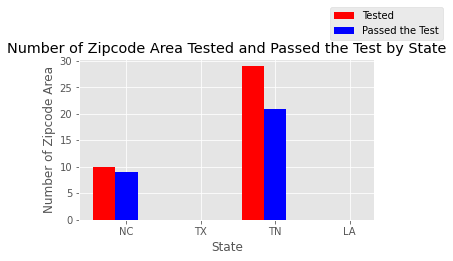

In [100]:
state_data_passed = ZRI_in_listing_area_from_2012[ZRI_in_listing_area_from_2012.zipcode.isin(list(pass_at_least_one_test.Zipcode.unique()))]
#ploting the count for areas passed the test by state 
state_data_to_test = ZRI_in_listing_area_from_2012[ZRI_in_listing_area_from_2012.zipcode.isin(granger_causality_test_results.keys())]

tested_sample_NC = len(state_data_to_test[state_data_to_test.state == 'NC'])
tested_sample_TX = len(state_data_to_test[state_data_to_test.state == 'TX'])
tested_sample_TN = len(state_data_to_test[state_data_to_test.state == 'TN'])
tested_sample_LA = len(state_data_to_test[state_data_to_test.state == 'LA'])

state_data_passed = ZRI_in_listing_area_from_2012[ZRI_in_listing_area_from_2012.zipcode.isin(list(pass_at_least_one_test.Zipcode.unique()))]
passed_sample_NC = len(state_data_passed[state_data_passed.state == 'NC'])
passed_sample_TX = len(state_data_passed[state_data_passed.state == 'TX'])
passed_sample_TN = len(state_data_passed[state_data_passed.state == 'TN'])
passed_sample_LA = len(state_data_passed[state_data_passed.state == 'LA'])


#plot
n_groups = 4
number_of_areas_to_test = [tested_sample_NC, tested_sample_TX, tested_sample_TN, tested_sample_LA]
number_of_areas_passed = [passed_sample_NC, passed_sample_TX, passed_sample_TN, passed_sample_LA]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1

rects1 = plt.bar(index, number_of_areas_to_test, bar_width,
alpha=opacity,
color='r',
label='Tested')

rects2 = plt.bar(index + bar_width, number_of_areas_passed, bar_width,
alpha=opacity,
color='b',
label='Passed the Test')

plt.xlabel('State')
plt.ylabel('Number of Zipcode Area')
plt.title('Number of Zipcode Area Tested and Passed the Test by State')
plt.xticks(index + bar_width,  ["NC", "TX", "TN", "LA"])
plt.legend(loc='best', bbox_to_anchor=(1.25, 1.35))
plt.tight_layout()
plt.show()

